In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# additional imports
import pandas as pd
import seaborn as sns
from pandas import read_pickle

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [ ]:
df = pd.read_pickle('path/Dataset/New_Preprocessed_Dataset.pkl')

In [3]:
# rename label : none to normal
df['label'] = df['label'].replace('none', 'normal')

In [ ]:
embeddings = np.array(df['embedding'].tolist()) 
labels = df['label'].tolist()  

In [5]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)

In [ ]:
pd.Series(y_test).value_counts()

normal    3116
sexism     977
racism     590
Name: count, dtype: int64

### SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [8]:
print("Distribution après SMOTE :", dict(zip(*np.unique(y_train_sm, return_counts=True))))

Distribution après SMOTE : {'normal': 7271, 'racism': 7271, 'sexism': 7271}


### RandomOverSampling

In [9]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [10]:
print("Distribution après ROS :", dict(zip(*np.unique(y_train_ros, return_counts=True))))

Distribution après ROS : {'normal': 7271, 'racism': 7271, 'sexism': 7271}


### GAN

In [ ]:
df_gan = read_pickle('path/Dataset/GAN_DF.pkl')

# remove 10 sexism samples
df_gan = df_gan.drop(df_gan[df_gan["label"] == "sexism"].sample(n=10, random_state=42).index)

# merge df_gan and x train and y train
X_train_gan = np.concatenate((X_train, df_gan['embedding'].tolist()), axis=0)
y_train_gan = np.concatenate((y_train, df_gan['label'].tolist()), axis=0)

In [18]:
print("Distribution après GAN :", dict(zip(*np.unique(y_train_gan, return_counts=True))))

Distribution après GAN : {'normal': 7271, 'racism': 2875, 'sexism': 7271}


## Decision Tree

In [ ]:
def train_dt_with_gridsearch(X_train, y_train, scoring_metric='f1_macro'):

    # parapeters for grid search
    param_grid_dt = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']  # ou 'log_loss' si sklearn >=1.1
    }

    dt_classifier = DecisionTreeClassifier(random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # grid search
    grid_search_dt = GridSearchCV(
        dt_classifier,
        param_grid=param_grid_dt,
        cv=cv,
        scoring=scoring_metric,
        n_jobs=-1,
        verbose=1
    )

    # training
    grid_search_dt.fit(X_train, y_train)

    return grid_search_dt

In [ ]:
def evaluate_model(grid_search, X_test, y_test, label="Model", cmap="Blues", class_names=["normal", "racism", "sexism"]):
    # Get the best classifier from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Predict on test set
    y_pred = best_clf.predict(X_test)

    # Compute metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    recall = round(recall_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted', zero_division=0), 2)

    print(f"\n--- Results for {label} ---")

    # Get unique labels (sorted)
    labels = sorted(np.unique(np.concatenate((y_test, y_pred))))
    if class_names is None:
        class_names = [str(l) for l in labels]

    # Raw confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print("Confusion matrix (raw values):")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({label})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Confusion matrix with percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.round(cm_percent, 1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({label}) - Percentages (%)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Classification report
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # Summary scores
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Best parameters found:", grid_search.best_params_)

    return best_clf

Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Results for DT with SMOTE ---
Confusion matrix (raw values):


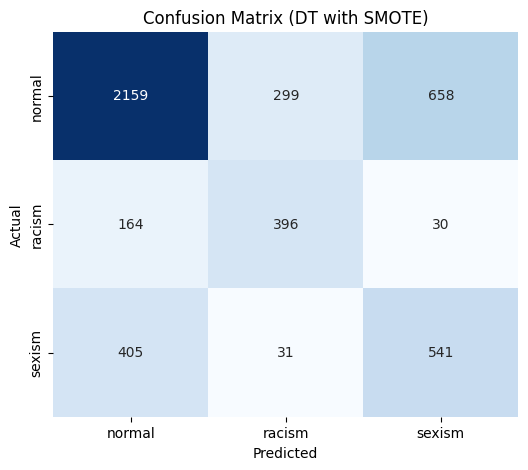

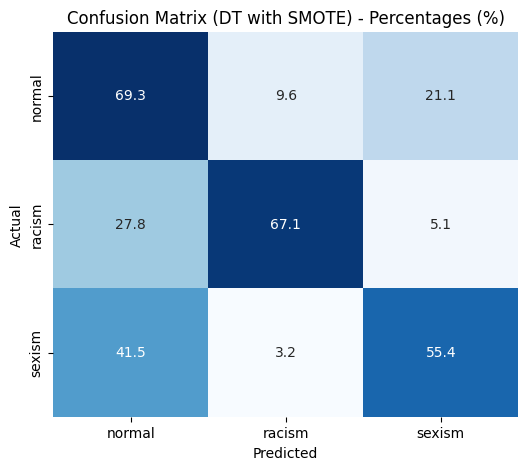


Classification report:
              precision    recall  f1-score   support

      normal       0.79      0.69      0.74      3116
      racism       0.55      0.67      0.60       590
      sexism       0.44      0.55      0.49       977

    accuracy                           0.66      4683
   macro avg       0.59      0.64      0.61      4683
weighted avg       0.69      0.66      0.67      4683

Accuracy: 0.66
Precision: 0.69
Recall: 0.66
F1-Score: 0.67
Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [22]:
grid_search_smote = train_dt_with_gridsearch(X_train_sm, y_train_sm)
evaluate_model(grid_search_smote, X_test, y_test, label="DT with SMOTE")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Results for DT with ROS ---
Confusion matrix (raw values):


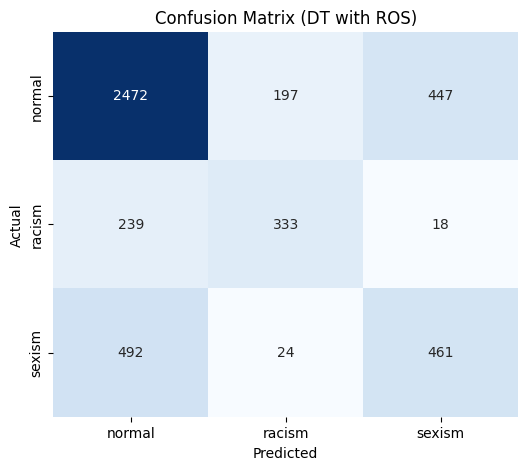

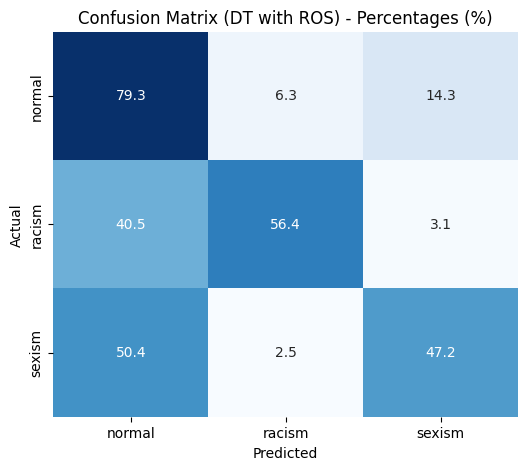


Classification report:
              precision    recall  f1-score   support

      normal       0.77      0.79      0.78      3116
      racism       0.60      0.56      0.58       590
      sexism       0.50      0.47      0.48       977

    accuracy                           0.70      4683
   macro avg       0.62      0.61      0.62      4683
weighted avg       0.69      0.70      0.70      4683

Accuracy: 0.7
Precision: 0.69
Recall: 0.7
F1-Score: 0.7
Best parameters found: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}


DecisionTreeClassifier(random_state=42)

In [23]:
grid_search_ros = train_dt_with_gridsearch(X_train_ros, y_train_ros)
evaluate_model(grid_search_ros, X_test, y_test, label="DT with ROS")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Results for DT with GAN ---
Confusion matrix (raw values):


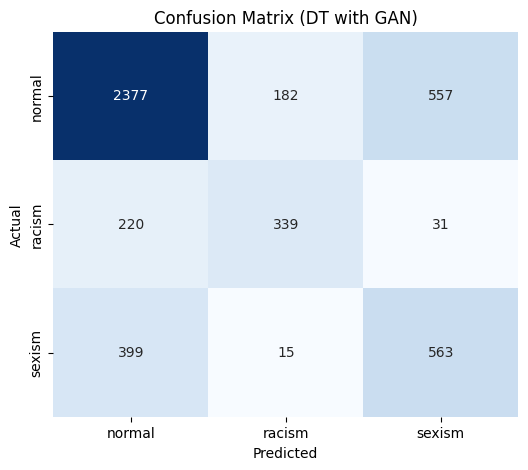

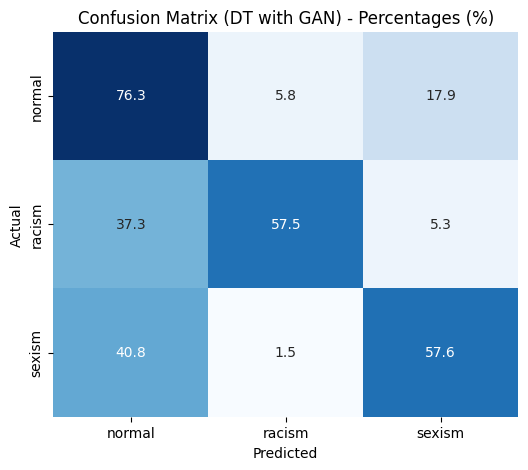


Classification report:
              precision    recall  f1-score   support

      normal       0.79      0.76      0.78      3116
      racism       0.63      0.57      0.60       590
      sexism       0.49      0.58      0.53       977

    accuracy                           0.70      4683
   macro avg       0.64      0.64      0.64      4683
weighted avg       0.71      0.70      0.70      4683

Accuracy: 0.7
Precision: 0.71
Recall: 0.7
F1-Score: 0.7
Best parameters found: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [24]:
grid_search_gan = train_dt_with_gridsearch(X_train_gan, y_train_gan)
evaluate_model(grid_search_gan, X_test, y_test, label="DT with GAN")

### Without Augmentation

Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Results for DT without augmentation ---
Confusion matrix (raw values):


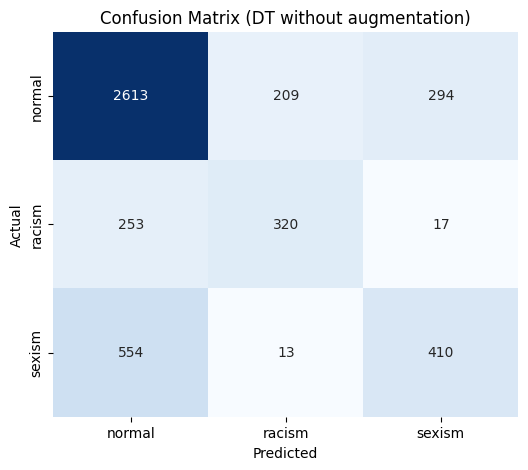

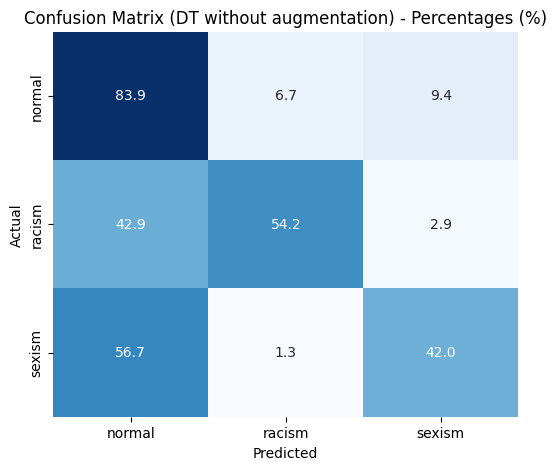


Classification report:
              precision    recall  f1-score   support

      normal       0.76      0.84      0.80      3116
      racism       0.59      0.54      0.57       590
      sexism       0.57      0.42      0.48       977

    accuracy                           0.71      4683
   macro avg       0.64      0.60      0.62      4683
weighted avg       0.70      0.71      0.70      4683

Accuracy: 0.71
Precision: 0.7
Recall: 0.71
F1-Score: 0.7
Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [25]:
grid_search = train_dt_with_gridsearch(X_train, y_train)
evaluate_model(grid_search, X_test, y_test, label="DT without augmentation")